##**Machine Learning for Kalbe Nutritionals**

Objective : Predicting Qty based on past data with ARIMA

###**Attribute information:**

1. Customer

- CustomerID : No Unik Customer
- Age : Usia Customer
- Gender : 0 Wanita, 1 Pria
- Marital Status : Married, Single (Blm menikah/Pernah menikah)
- Income : Pendapatan per bulan dalam jutaan rupiah


2. Store

- StoreID : Kode Unik Store
- StoreName : Nama Toko
- GroupStore : Nama group
- Type : Modern Trade, General Trade
- Latitude : Kode Latitude
- Longitude : Kode Longitude


3. Product

- ProductID : Kode Unik Product
- Product Name : Nama Product
- Price : Harga dlm rupiah


4. Transaction

- TransactionID : Kode Unik Transaksi
- Date : Tanggal transaksi
- Qty : Jumlah item yang dibeli
- Total Amount : Price x Qty





# Import Library dan Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

### Load Dataset

In [ ]:
df_cus = pd.read_csv('Customer.csv')
df_str = pd.read_csv('Store.csv')
df_prod = pd.read_csv('Product.csv')
df_trans = pd.read_csv('Transaction.csv')

### Data Preprocessing

#### Customer

In [ ]:
df_cus = df_cus.drop_duplicates()

In [ ]:
#Looking at the first 5 rows of the dataset
df_cus.head()

,CustomerID,Age,Gender,MaritalStatus,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [ ]:
#Looking at the last 5 rows of the dataset
df_cus.tail()

,CustomerID,Age,Gender,MaritalStatus,Income
442,443,33,1,NaN,9.28
443,444,53,0,Married,15.31
444,445,51,0,Married,14.48
445,446,57,0,Married,7.81
446,447,54,1,Married,20.37


In [ ]:
#How many rows and columns in the dataset?
df_cus.shape

(447, 5)

In [ ]:
#Labeling categorical data
status = {
    "Single": 0,
    "Married": 1
}

df_cus['MaritalStatus'] = df_cus['MaritalStatus'].map(status)

In [ ]:
df_cus.head()

,CustomerID,Age,Gender,MaritalStatus,Income
0,1,55,1,1.0,5.12
1,2,60,1,1.0,6.23
2,3,32,1,1.0,9.17
3,4,31,1,1.0,4.87
4,5,58,1,1.0,3.57


In [ ]:
#General information of the dataset
df_cus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     447 non-null    int64  
 1   Age            447 non-null    int64  
 2   Gender         447 non-null    int64  
 3   MaritalStatus  444 non-null    float64
 4   Income         447 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 17.6 KB


##### Handling Missing Values

In [ ]:
#Checking for missing values
df_cus.isnull().sum()

CustomerID       0
Age              0
Gender           0
MaritalStatus    3
Income           0
dtype: int64

In [ ]:
#filling missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_cus[['MaritalStatus']])
df_cus['MaritalStatus'] = imputer.transform(df_cus[['MaritalStatus']])

In [ ]:
#Checking if the data is still missing
df_cus.isnull().sum()

CustomerID       0
Age              0
Gender           0
MaritalStatus    0
Income           0
dtype: int64

#### Store

In [ ]:
df_str = df_str.drop_duplicates()

In [ ]:
#Looking at the first 5 rows of the dataset
df_str.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [ ]:
#Looking at the last 5 rows of the dataset
df_str.tail()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
9,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513
10,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403
11,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
12,13,Buana,Buana,General Trade,-1.269160,116.825264
13,14,Priangan,Priangan,Modern Trade,-5.450000,105.266670


In [ ]:
#How many rows and columns in the dataset?
df_str.shape

(14, 6)

In [ ]:
#General information of the dataset
df_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


##### Handling Missing Values

In [ ]:
#Checking for missing values
df_str.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

#### Product

In [ ]:
df_prod = df_prod.drop_duplicates()

In [ ]:
#Looking at the first 5 rows of the dataset
df_prod.head()

,ProductID,ProductName,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
#Looking at the last 5 rows of the dataset
df_str.tail()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
9,10,Harapan Baru,Harapan Baru,General Trade,3.597031,98.678513
10,11,Sinar Harapan,Prestasi,General Trade,0.533505,101.447403
11,12,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
12,13,Buana,Buana,General Trade,-1.269160,116.825264
13,14,Priangan,Priangan,Modern Trade,-5.450000,105.266670


In [ ]:
#How many rows and columns in the dataset?
df_prod.shape

(10, 3)

In [ ]:
#General information of the dataset
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    10 non-null     object
 1   ProductName  10 non-null     object
 2   Price        10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


##### Handling Missing Values

In [ ]:
#Checking for missing values
df_prod.isnull().sum()

ProductID      0
ProductName    0
Price          0
dtype: int64

#### Transaction

In [ ]:
df_trans = df_trans.drop_duplicates()

In [ ]:
#Looking at the first 5 rows of the dataset
df_trans.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,1/1/2022,P3,7500,4,30000,12
1,TR16356,165,1/1/2022,P9,10000,7,70000,1
2,TR1984,183,1/1/2022,P1,8800,4,35200,4
3,TR35256,160,1/1/2022,P1,8800,7,61600,4
4,TR41231,386,1/1/2022,P9,10000,1,10000,4


In [ ]:
#Looking at the last 5 rows of the dataset
df_trans.tail()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13
5019,TR85684,55,31/12/2022,P8,16000,1,16000,6


In [ ]:
#How many rows and columns in the dataset?
df_trans.shape

(5020, 8)

In [ ]:
#General information of the dataset
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


##### Handling Missing Values

In [ ]:
#Checking for missing values
df_trans.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

### Merging Dataset

In [ ]:
df1 = df_trans.merge(df_cus, on='CustomerID', how='inner')
df2 = df1.merge(df_str, on='StoreID', how='inner')
df = df2.merge(df_prod.drop(columns=['Price']), on='ProductID', how='inner')

In [ ]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,MaritalStatus,Income,StoreName,GroupStore,Type,Latitude,Longitude,ProductName
0,TR11369,328,1/1/2022,P3,7500,4,30000,12,36,0,1.0,10.53,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,0.0,0.18,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,1.0,4.36,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
3,TR4331,335,8/1/2022,P3,7500,3,22500,12,29,1,0.0,4.74,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
4,TR6445,181,10/1/2022,P3,7500,4,30000,12,33,1,1.0,9.94,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers


In [ ]:
df.describe()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,MaritalStatus,Income,Latitude,Longitude
count,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,221.263745,9684.800797,3.644622,32279.482072,7.489841,40.003586,0.452988,0.759501,8.659839,-2.942236,109.600789
std,129.672955,4600.708780,1.855295,19675.462455,4.028502,12.834719,0.497835,0.425586,6.507063,4.323225,8.357593
min,1.000000,3200.000000,1.000000,7500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.797068,95.323753
25%,108.000000,4200.000000,2.000000,16000.000000,4.000000,30.000000,0.000000,1.000000,4.360000,-6.914864,104.756554
50%,221.000000,9400.000000,3.000000,28200.000000,7.000000,39.000000,0.000000,1.000000,7.810000,-5.135399,110.370529
75%,332.000000,15000.000000,5.000000,47000.000000,11.000000,51.000000,1.000000,1.000000,10.780000,0.533505,114.590111
max,447.000000,18000.000000,10.000000,88000.000000,14.000000,72.000000,1.000000,1.000000,71.300000,5.548290,128.190643


In [ ]:
df = df.groupby('Date').agg({'Qty': 'sum'}).reset_index()

df.head()

,Date,Qty
0,1/1/2022,49
1,1/10/2022,85
2,1/11/2022,66
3,1/12/2022,81
4,1/2/2022,50


In [ ]:
#Describing the dataset
df.describe()

,Qty
count,365.000000
mean,50.126027
std,16.704461
min,15.000000
25%,38.000000
50%,49.000000
75%,59.000000
max,119.000000


# Data Exploration

In [ ]:
df.isnull().sum()/len(df)

Date    0.0
Qty     0.0
dtype: float64

In [ ]:
print(df.dtypes)

Date    object
Qty      int64
dtype: object


In [ ]:
#Changing date to index
con = df['Date']
df['Date']=pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date')
#check datatype of index
df.index

RangeIndex(start=0, stop=365, step=1)

In [ ]:
df

,Date,Qty
0,2022-01-01,49
1,2022-10-01,85
2,2022-11-01,66
3,2022-12-01,81
4,2022-02-01,50
...,...,...
360,2022-05-09,75
361,2022-06-09,55
362,2022-07-09,44
363,2022-08-09,73


In [ ]:
#Qty as time series variable
ts = df['Qty']
ts.head(10)

0    49
1    85
2    66
3    81
4    50
5    76
6    98
7    67
8    67
9    99
Name: Qty, dtype: int64

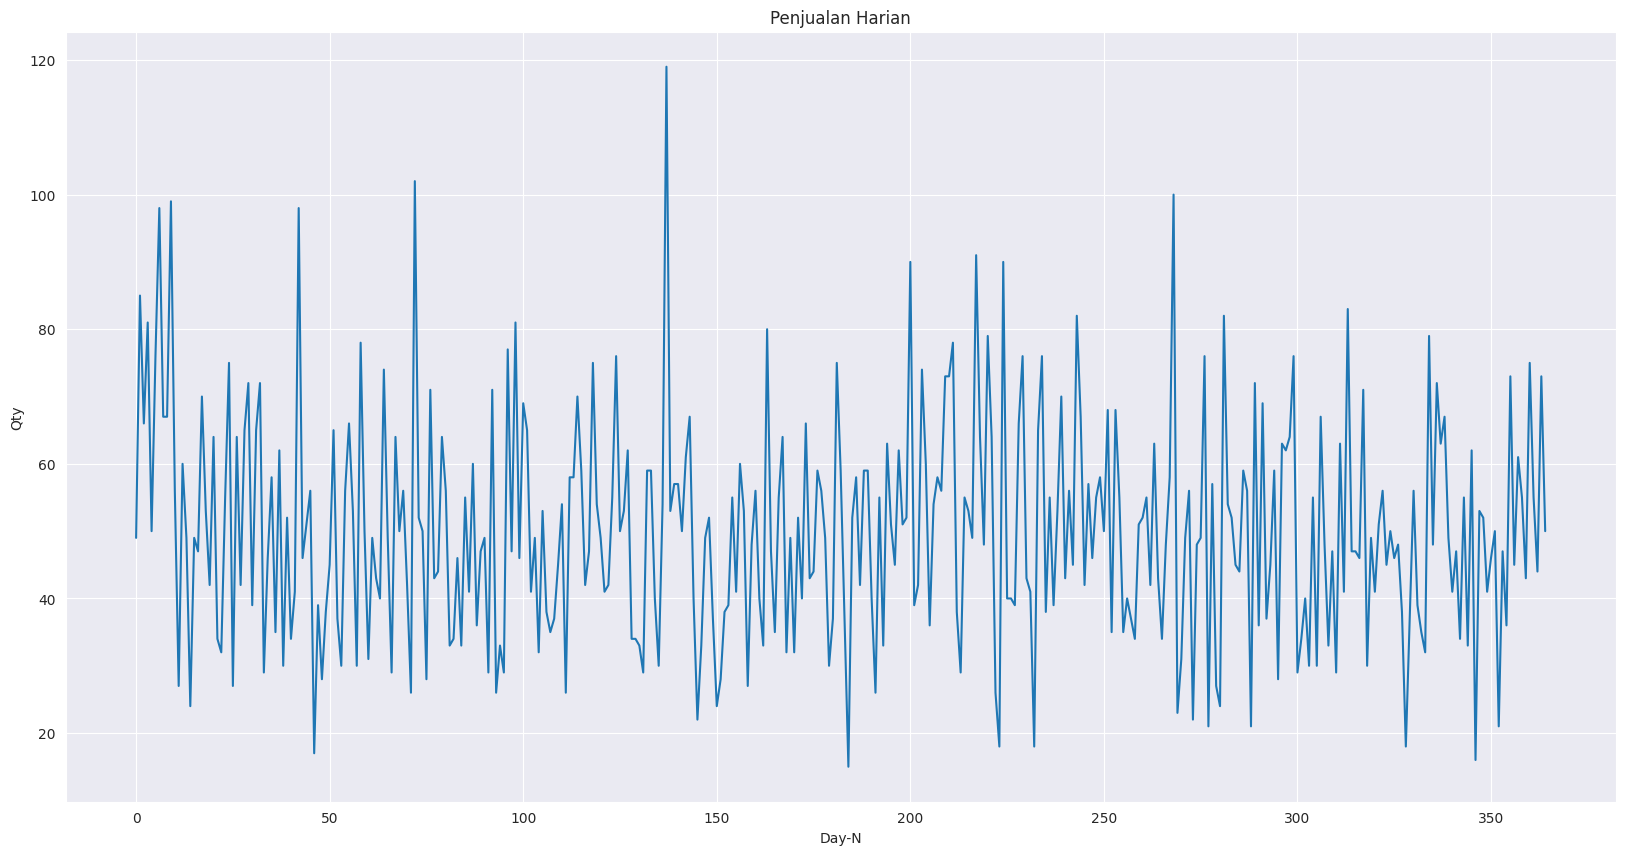

In [ ]:
#Dataset visualization
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Day-N')
plt.ylabel('Qty')
plt.title('Penjualan Harian')
plt.plot(df['Qty'])

## Uji Stasioneritas Data

In [ ]:
#Deklarasi fungsi untuk mengecek stasioneritas data
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Uji Hipotesis:

H0 : Data tidak stasioner

Ha : Data stasioner

Tolak H0 apabila diperoleh p-value < alpha (0,05)

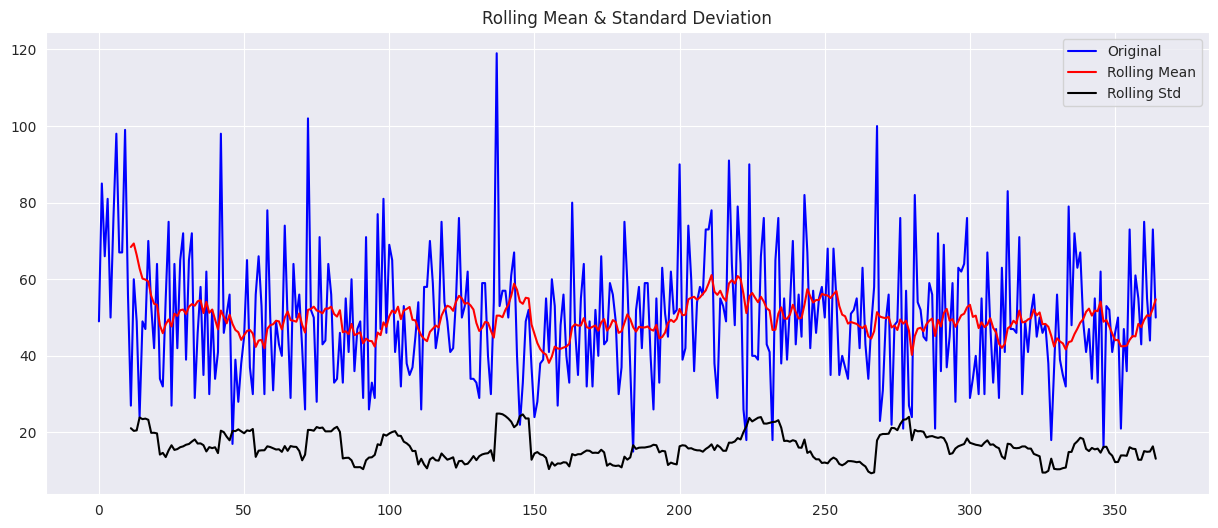

Results of Dickey-Fuller Test:
Test Statistic                 -19.589392
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


In [ ]:
#Melakukan uji stasioneritas untuk dataset
test_stationarity(ts)

Keadaan data stasioner karena p-value < 0.05

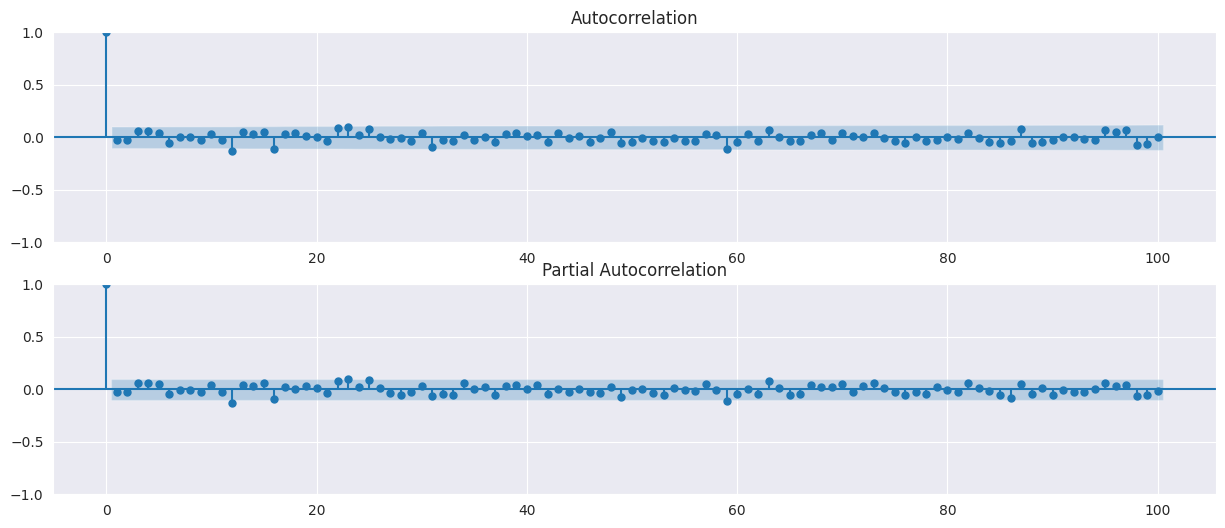

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca(), lags=100)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(), lags=100)
plt.show()

Plot ACF dan plot PACF dibentuk untuk mengetahui orde dari AR dan MA, sehingga bisa diketahui model yang sesuai untuk data.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


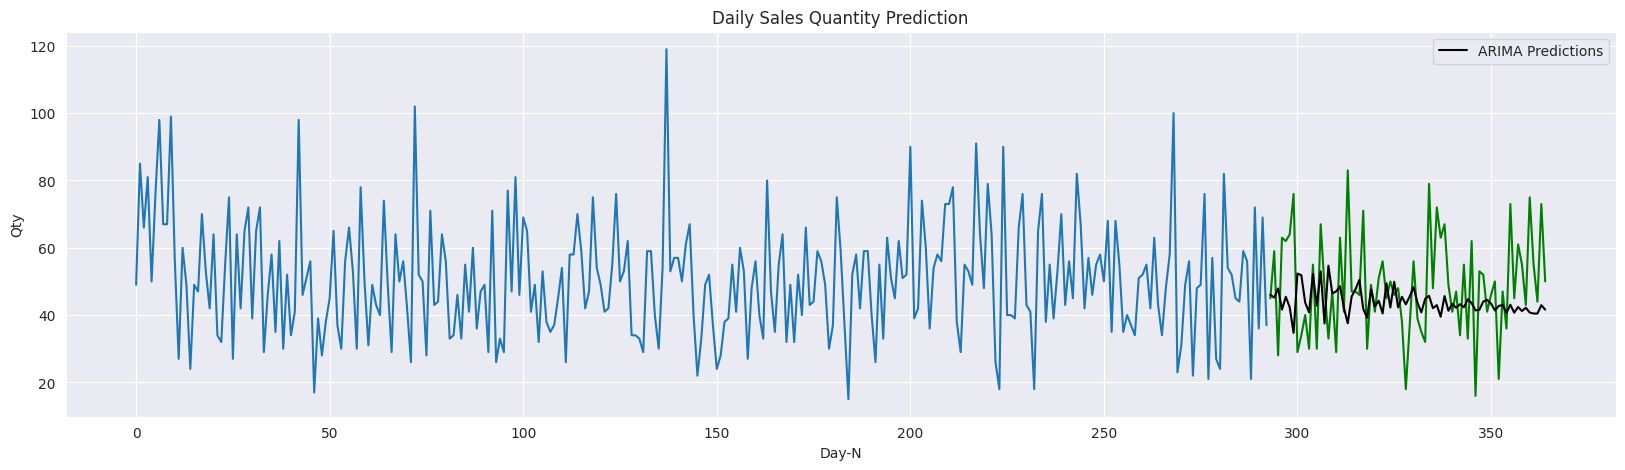

In [ ]:
#Splitting Data 80:20
train, test = df[:293], df[293:]

y = train['Qty']

#ARIMA
ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['predictions']

plt.figure(figsize=(20,5))
plt.title("Daily Sales Quantity Prediction")
plt.plot(train['Qty'])
plt.plot(test['Qty'], color='green')
plt.xlabel("Day-N")
plt.ylabel("Qty")
plt.plot(y_pred_out, color='black', label='ARIMA Predictions')
plt.legend()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_actual = test['Qty']

# Calculating the metrics
mae = mean_absolute_error(y_actual, y_pred_out)
mse = mean_squared_error(y_actual, y_pred_out)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_actual - y_pred_out) / y_actual)) * 100

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 12.85
Mean Squared Error (MSE): 271.13
Root Mean Squared Error (RMSE): 16.47
Mean Absolute Percentage Error (MAPE): 28.85%


In [ ]:
ARIMAmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  293
Model:                ARIMA(40, 2, 1)   Log Likelihood               -1228.723
Date:                Sat, 13 Jul 2024   AIC                           2541.447
Time:                        18:58:13   BIC                           2695.726
Sample:                             0   HQIC                          2603.252
                                - 293                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0287      0.076    -13.516      0.000      -1.178      -0.880
ar.L2         -1.0939      0.113     -9.722      0.000      -1.314      -0.873
ar.L3         -1.0069      0.151     -6.686      0.000      -1.302      -0.712
ar.L4         -0.9472      0.179     -5.295      0.000      -1.298      -0.597
ar.L5         -0.9189      0.201     -4.563      0.000      -1.314      -0.524
ar.L6         -0.9173      0.225     -4.069      0.000      -1.359      -0.475
ar.L7         -0.9106      0.242     -3.769      0.000      -1.384      -0.437
ar.L8         -0.8794      0.270     -3.257      0.001      -1.408      -0.350
ar.L9         -0.8645      0.282     -3.067      0.002      -1.417      -0.312
ar.L10        -0.8259      0.290     -2.845      0.004      -1.395      -0.257
ar.L11        -0.7936      0.312     -2.542      0.011      -1.405      -0.182
ar.L12        -0.9287      0.323     -2.878      0.004      -1.561      -0.296
ar.L13        -0.8454      0.345     -2.450      0.014      -1.522      -0.169
ar.L14        -0.7859      0.360     -2.184      0.029      -1.491      -0.081
ar.L15        -0.7291      0.373     -1.954      0.051      -1.460       0.002
ar.L16        -0.8278      0.381     -2.173      0.030      -1.574      -0.081
ar.L17        -0.7853      0.386     -2.035      0.042      -1.542      -0.029
ar.L18        -0.7525      0.387     -1.942      0.052      -1.512       0.007
ar.L19        -0.6906      0.403     -1.714      0.087      -1.480       0.099
ar.L20        -0.6600      0.413     -1.600      0.110      -1.469       0.149
ar.L21        -0.7053      0.407     -1.733      0.083      -1.503       0.092
ar.L22        -0.5730      0.407     -1.406      0.160      -1.372       0.226
ar.L23        -0.4640      0.399     -1.162      0.245      -1.247       0.319
ar.L24        -0.4299      0.400     -1.074      0.283      -1.214       0.354
ar.L25        -0.2893      0.381     -0.760      0.447      -1.035       0.457
ar.L26        -0.2913      0.374     -0.779      0.436      -1.025       0.442
ar.L27        -0.2463      0.355     -0.694      0.488      -0.942       0.449
ar.L28        -0.3130      0.336     -0.933      0.351      -0.971       0.345
ar.L29        -0.2640      0.317     -0.833      0.405      -0.885       0.357
ar.L30        -0.2452      0.300     -0.817      0.414      -0.833       0.343
ar.L31        -0.3554      0.270     -1.318      0.187      -0.884       0.173
ar.L32        -0.3816      0.263     -1.452      0.147      -0.897       0.134
ar.L33        -0.3934      0.249     -1.581      0.114      -0.881       0.094
ar.L34        -0.2558      0.231     -1.105      0.269      -0.709       0.198
ar.L35        -0.2221      0.197     -1.125      0.260      -0.609       0.165
ar.L36        -0.1849      0.186     -0.995      0.320      -0.549       0.179
ar.L37        -0.2186      0.175     -1.248      0.212      -0.562       0.125
ar.L38        -0.1861      0.151     -1.233      0.217      -0.482       0.110
ar

In [ ]:
forecast_steps = 30
forecast = ARIMAmodel.forecast(steps=forecast_steps)

print('Forecasted Values:')
print(forecast)

Forecasted Values:
293    46.031005
294    45.196884
295    47.903899
296    41.640396
297    45.437782
298    42.321716
299    34.709932
300    52.339710
301    51.865845
302    43.710089
303    40.802897
304    52.208468
305    42.767521
306    53.004290
307    37.507959
308    54.663922
309    46.433434
310    47.026179
311    48.581045
312    42.152861
313    37.551685
314    45.498599
315    47.676398
316    50.461829
317    41.827206
318    39.211086
319    47.635435
320    42.558421
321    44.255392
322    40.488120
Name: predicted_mean, dtype: float64
